# Homework 2 | Exploring Options | Tasks 1-4 due 09/22/25 | Task 5 due 09/24/25

Now that you have all of the options data stored locally on your computer and in pkl files, we can begin working with it. Your task will be to edit the monthly data and make some observations about its structure. See below.

## Tasks

### 1. For each file, remove the following columns: ['ImpliedVolatility', 'Delta','Gamma', 'Vega', 'Theta']

### 2. Add a column for the SPX index. MAKE SURE THE DATES MATCH! Hint: You might want to set the index of the options data to the date column... If yFinance doesn't let you download the SPX data skip this for now.

### 2. On paper or using markdown, use your knowledge of calculus to compute explicit formulas for the Greeks we discussed

### 3. Add columns of the Greeks using your formulae

### 4. Using the Newton Raphson method discussed on 9/17/25, calculate implied volatilies for each option and add this as a column to the data

### 5. Now plot the following and keep an eye out for specific relationships. We will talk about what we notice.

### 5.1 Using the ATM Strike and fixed date, plot the following:
* Call delta vs. time to maturity
* Call gamma vs. time to maturity
* Call theta vs. time to maturity
* Call vega vs. time to maturity
* Call implied volatility vs. time to maturity

Do the same for puts. What do you notice about the greeks for calls and puts?

### 5.2 From the span of 2015-2020:
* Calculate a 5,21,63,129 rolling realiezd volatilities for SPX
* Plot the implied volatilties for ATM options expiring at roughly the same 5,21,63,129 date marks. What I mean by this is, iterate through the data and calculate the implied volatility for ATM calls expriing in those times for every single day. You won't be using the same option for the 5 years if you get what I mean... Maybe it's clear already, and I'm being dramatic.
* Make some plots of IV - RV. What do you notice? When does the graph become positive?

### 5.3 Pick a date and maturity of your own choice and plot the following:
* Strike vs. delta
* Strike vs. theta
* Strike vs. IV
* Strike vs. option price

Feel free to do any additional analysis with the data at any time by the way. We are getting familiar with how options work here!

## Your work starts here

In [2]:
import numpy as np
import yfinance as yf
import os
import pandas as pd

SPX = yf.Ticker("^GSPC")
df_SPX = SPX.history(period="30y", interval="1d")
df_SPX.index = df_SPX.index.tz_localize(None)
close_series = df_SPX['Close'].round(3)

folder = r"C:\TAMID\OptionsData"

drop_cols = ['ImpliedVolatility', 'Delta','Gamma', 'Vega', 'Theta']

for file in os.listdir(folder):
    if file.endswith(".pkl"):
        file_path = os.path.join(folder, file)

        df = pd.read_pickle(file_path)
        header_str = df.columns[0]
        new_columns = header_str.split('\t')

        df = df.iloc[:,0].str.split("\t", expand=True)
        df.columns = new_columns
        df["Date"] = pd.to_datetime(df["Date"].astype(str), format = "%Y%m%d")
        #print(df.head())
        df = df.drop(drop_cols, axis=1, errors='ignore')
        df.set_index("Date", inplace=True)
        df["SPX"] = close_series.reindex(df.index)

        df.to_pickle(file_path)

In [ ]:
    import numpy as np
from scipy.stats import norm
from scipy.optimize import newton, brentq
import pandas as pd
import os

r= 0.04
sigma = 0.2 # Vol Guess

folder = r"C:\TAMID\OptionsData"

def d1_d2(S, K, T, r, sigma):
    sigma = np.clip(sigma, 1e-8, 5.0)
    T = np.maximum(T, 1e-8)
    sqrtT = np.sqrt(T)
    d1 = (np.log(S / K) + (r + 0.5 * sigma ** 2) * T) / (sigma * sqrtT)
    d2 = d1 - sigma * sqrtT
    return d1, d2

def black_scholes_price(S, K, T, r, sigma, option_type='C') :
    d1, d2 = d1_d2(S, K, T, r, sigma)
    if option_type == "C":
        return (S * norm.cdf(d1)) - (K * np.exp(-r * T) * norm.cdf(d2))
    else:
        return (K * np.exp(-r * T) * norm.cdf(-d2)) - (S * norm.cdf(-d1))
#-----------------GREEKS-----------------
def delta(S, K, T, r, sigma, option_type = 'C'):
    d1, _ = d1_d2(S, K, T, r, sigma)
    if option_type == 'C':
        return norm.cdf(d1)
    else:
        return norm.cdf(d1) - 1

def gamma(S, K, T, r, sigma):
    d1, _ = d1_d2(S, K, T, r, sigma)
    return norm.pdf(d1) / (S * sigma * np.sqrt(T))

def theta(S, K, T, r, sigma, option_type = 'C'):
    d1, d2 = d1_d2(S, K, T, r, sigma)

    first = - (S * norm.pdf(d1) * sigma) / (2 * np.sqrt(T))

    if option_type == 'C':
        return first - r * K * np.exp(-r * T) * norm.cdf(d2)
    else:  # put
        return first + r * K * np.exp(-r * T) * norm.cdf(-d2)

def vega(S, K, T, r, sigma):
    d1, _ = d1_d2(S, K, T, r, sigma)
    return S * norm.pdf(d1) * np.sqrt(T)

def inflexion_point(S, K, T, r) :
    m = S / (K * np.exp(-r * T))
    return np.sqrt(2 * abs(np.log(m) / T))

#-----------------ImpliedVol-----------------

def implied_vol_newton(S, K, T, r, market_price, option_type = 'C', sigma_init = 0.2, tol = 1e-8, maxiter = 100, max_step = 0.5, sigma_min = 1e-8, sigma_max = 5.0):

    try:
        S = float(S); K = float(K); T = float(T); market_price = float(market_price)
    except Exception:
        return -99.99

    if not np.isfinite(S) or not np.isfinite(K) or not np.isfinite(T) or not np.isfinite(market_price):
        return -99.99

    # No-arbitrage bounds
    discK = K * np.exp(-r * T)
    if option_type.upper().startswith('C'):
        lower = max(0.0, S - discK)
        upper = S
    else:
        lower = max(0.0, discK - S)
        upper = discK
    if (market_price < lower - 1e-12) or (market_price > upper + 1e-12):
        return -99.99
    if np.isclose(market_price, lower, atol=1e-12) or np.isclose(market_price, upper, atol=1e-12):
        return sigma_min

    def f(sigma):
        return black_scholes_price(S, K, T, r, sigma, option_type) - market_price

    def fprime(sigma):
        v = vega(S, K, T, r, sigma)
        if not np.isfinite(v) or v == 0.0:
            raise RuntimeError("invalid vega")
        return v

    x0 = float(np.clip(sigma_init, sigma_min, sigma_max))

    try:
        iv = newton(f, x0=x0, fprime=fprime, tol=tol, maxiter=maxiter)
        if not np.isfinite(iv) or iv < sigma_min or iv > sigma_max:
            raise RuntimeError("sigma out of bounds")
        return iv
    except Exception:
        # Fallback to a bracket method
        try:
            iv = brentq(f, sigma_min, sigma_max)
            return iv
        except Exception:
            print(f"No IV for S={S}, K={K}, T={T}, price={market_price}, type={option_type}")
            return -99.99


for file_i, file in enumerate(os.listdir(folder), start = 1):
    if not file.endswith(".pkl"):
        continue

    file_path = os.path.join(folder, file)
    print(f"\n=== [{file_i}] Processing file: {file} ===")
    df = pd.read_pickle(file_path)
    print(f"Loaded {len(df):,} rows")

    df["SPX"] = pd.to_numeric(df["SPX"], errors="coerce")
    df["Strike"] = pd.to_numeric(df["Strike"], errors="coerce")
    df["BestBid"] = pd.to_numeric(df["BestBid"], errors="coerce")
    df["BestOffer"] = pd.to_numeric(df["BestOffer"], errors="coerce")

    #-----------------HELPERS------------------------
    df["Expiration"] = pd.to_datetime(df["Expiration"], format="%Y%m%d")
    df["T"] = (df["Expiration"] - df.index).dt.days / 365
    df["T"] = df["T"].clip(lower=1e-8)
    df["DaysToExpiration"] = df["T"] * 365
    df["Mid"] = (df["BestBid"] + df["BestOffer"]) / 2

    #df["InflexionPoint"] = inflexion_point(df["SPX"], df["Strike"], df["T"], r)

    S_arr     = df["SPX"].values
    K_arr     = df["Strike"].values
    T_arr     = df["T"].values
    Mid_arr   = df["Mid"].values
    Type_arr  = df["CallPut"].values

    print("Calculating implied volatilities...")
    implied_vols = [
        implied_vol_newton(S, K, T, r, Mid, opt_type)
        for S, K, T, Mid, opt_type in zip(S_arr, K_arr, T_arr, Mid_arr, Type_arr)
        ]
    df["ImpliedVolatility"] = implied_vols

    print("Computing Greeks...")
    for cp in ["C", "P"]:
        mask = df["CallPut"] == cp
        S = df.loc[mask, "SPX"]
        K = df.loc[mask, "Strike"]
        T = df.loc[mask, "T"]
        sigma = df.loc[mask, "ImpliedVolatility"]

        bad_mask = (sigma == -99.99)

        df.loc[mask, "BlackScholes"] = np.where(bad_mask, -99.99, black_scholes_price(S, K, T, r, sigma, cp))
        df.loc[mask, "Delta"] = np.where(bad_mask, -99.99, delta(S, K, T, r, sigma, cp))
        df.loc[mask, "Theta"] = np.where(bad_mask, -99.99, theta(S, K, T, r, sigma, cp))

    S = df["SPX"]
    K = df["Strike"]
    T = df["T"]
    sigma = df["ImpliedVolatility"]
    bad_mask = (sigma == -99.99)

    df["Gamma"] = np.where(bad_mask, -99.99, gamma(S, K, T, r, sigma))
    df["Vega"] = np.where(bad_mask, -99.99, vega(S, K, T, r, sigma))

    pd.set_option("display.max_rows", None)     # None = no limit
    pd.set_option("display.max_columns", None)

    df.to_pickle(file_path)
    print(f"Finished file: {file}\n")

read df


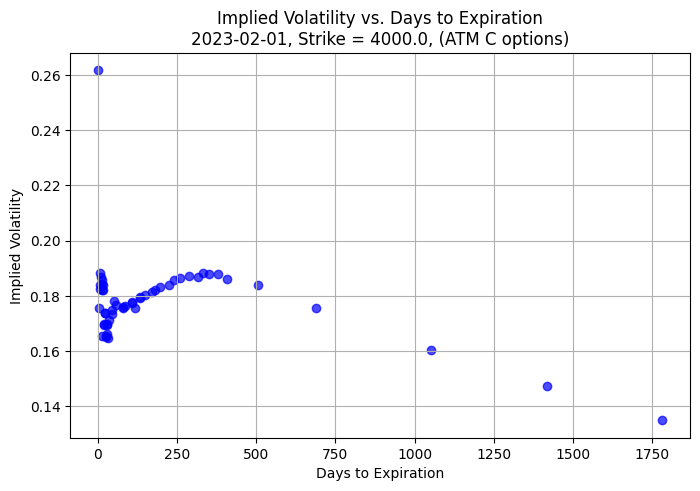

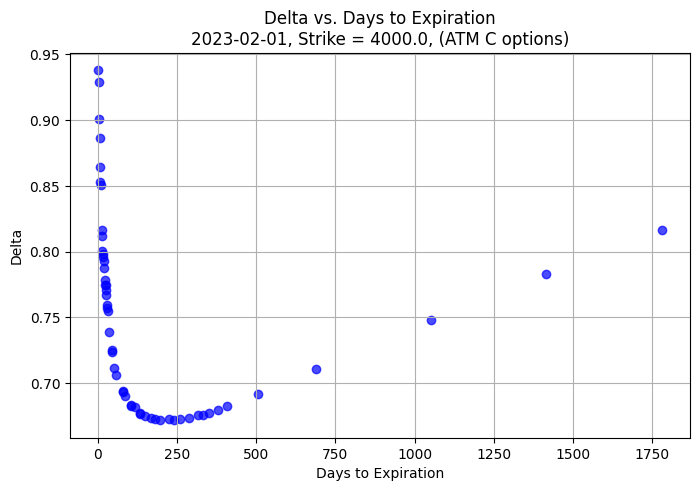

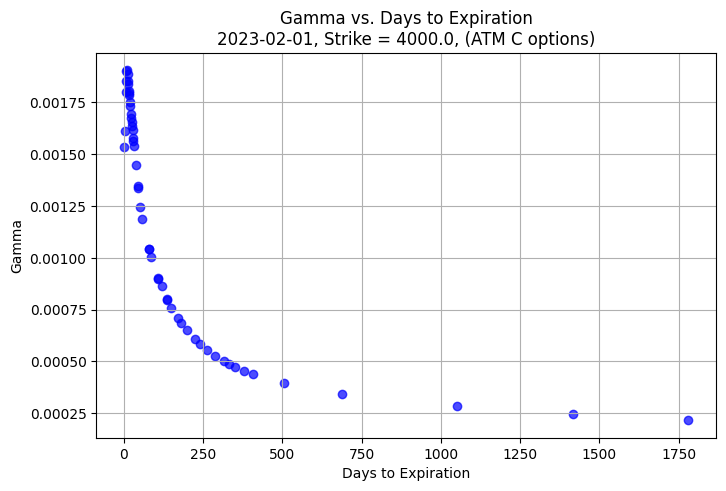

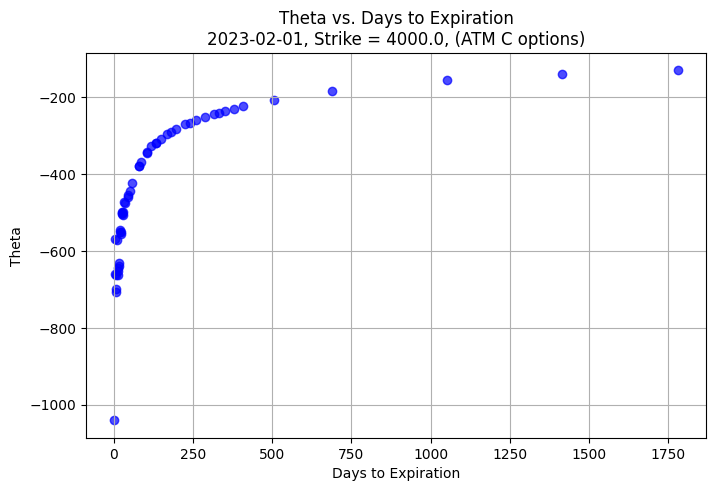

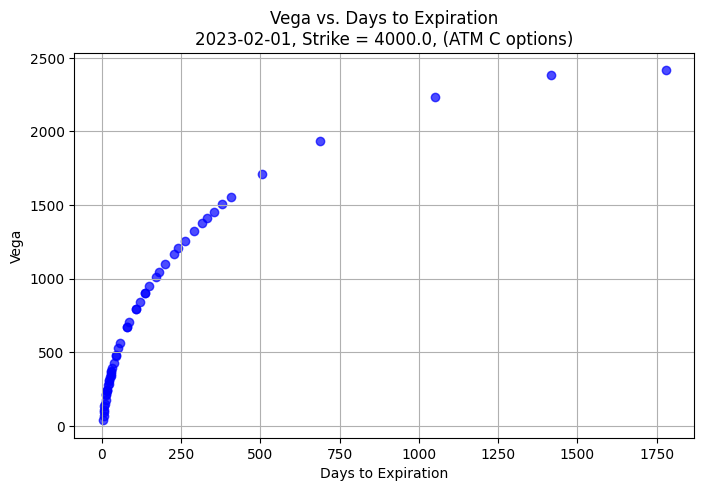

In [32]:
import matplotlib.pyplot as plt
import pandas as pd

file_name = r"C:\TAMID\OptionsData\IVYOPPRCD_202302.pkl"
df = pd.read_pickle(file_name)
print("read df")



STRIKE = 4000.0
DATE = pd.Timestamp("2023-02-01")
option_type = 'C'

filtered = df.loc[(df.index == DATE) & (df['CallPut'] == option_type) & (df['Strike'] == STRIKE)].copy()
for col in ['ImpliedVolatility', 'Delta', 'Gamma', 'Theta', 'Vega']:
    filtered = filtered[filtered[col] != -99.99]

filtered = filtered[filtered["Strike"] == STRIKE]

filtered = filtered.copy()
filtered["Date"] = filtered.index

#print(filtered)

metrics = {
    'ImpliedVolatility': 'Implied Volatility',
    'Delta': 'Delta',
    'Gamma': 'Gamma',
    'Theta': 'Theta',
    'Vega': 'Vega'
}

for col, title in metrics.items():
    plt.figure(figsize=(8, 5))
    if not filtered.empty and filtered['DaysToExpiration'].notna().any() and filtered[col].notna().any():
        plt.scatter(filtered['DaysToExpiration'], filtered[col], color='blue', alpha=0.7)

        x_min, x_max = filtered['DaysToExpiration'].min(skipna=True), filtered['DaysToExpiration'].max(skipna=True)
        x_pad = (x_max - x_min) * 0.05
        plt.xlim(x_min - x_pad, x_max + x_pad)

        # y-axis padding
        y_min, y_max = filtered[col].min(skipna=True), filtered[col].max(skipna=True)
        y_pad = (y_max - y_min) * 0.05
        plt.ylim(y_min - y_pad, y_max + y_pad)
    else:
        print("Warning: filtered DataFrame is empty or contains no valid values.")
    plt.title(f"{title} vs. Days to Expiration\n{DATE.date()}, Strike = {STRIKE}, (ATM {option_type} options)")
    plt.xlabel("Days to Expiration")
    plt.ylabel(title)
    plt.grid(True)
    plt.show()

In [ ]:
import pandas as pd
file_name = r"C:\TAMID\OptionsData\IVYOPPRCD_202302.pkl"
df = pd.read_pickle(file_name)
print(df.head(10))

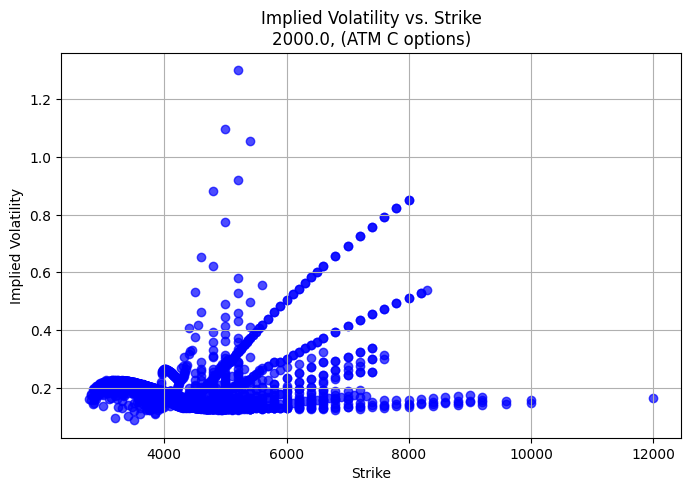

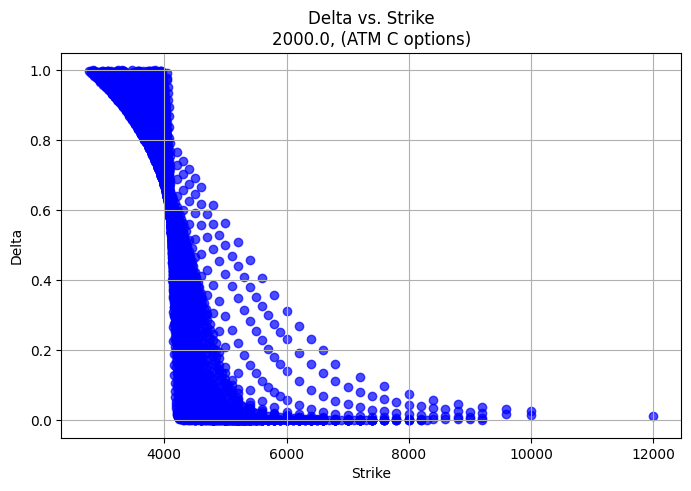

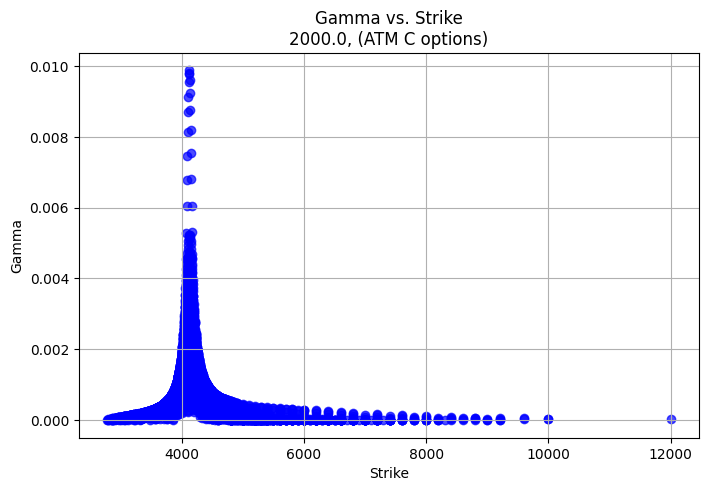

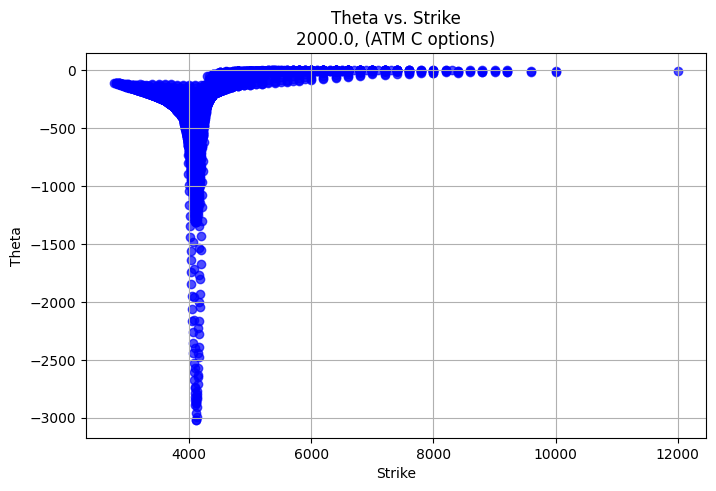

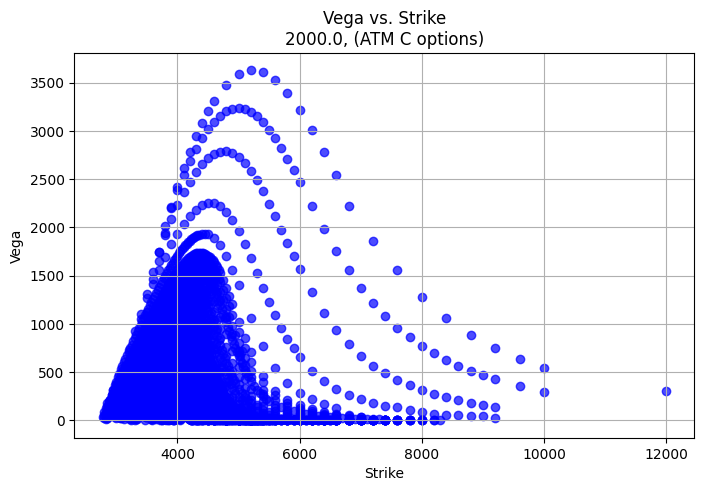

In [24]:
import matplotlib.pyplot as plt
import pandas as pd

file_name = r"C:\TAMID\OptionsData\IVYOPPRCD_202302.pkl"
df = pd.read_pickle(file_name)

DATE = pd.Timestamp("2023-02-01")
option_type = 'C'

filtered = df.loc[(df.index == DATE) & (df['CallPut'] == option_type)].copy()
for col in ['ImpliedVolatility', 'Delta', 'Gamma', 'Theta', 'Vega']:
    filtered = filtered[filtered[col] != -99.99]


for col, title in metrics.items():
    plt.figure(figsize=(8, 5))
    if not filtered.empty and filtered['Strike'].notna().any() and filtered[col].notna().any():
        plt.scatter(filtered['Strike'], filtered[col], color='blue', alpha=0.7)

        x_min, x_max = filtered['Strike'].min(skipna=True), filtered['Strike'].max(skipna=True)
        x_pad = (x_max - x_min) * 0.05
        plt.xlim(x_min - x_pad, x_max + x_pad)

        # y-axis padding
        y_min, y_max = filtered[col].min(skipna=True), filtered[col].max(skipna=True)
        y_pad = (y_max - y_min) * 0.05
        plt.ylim(y_min - y_pad, y_max + y_pad)
    else:
        print("Warning: filtered DataFrame is empty or contains no valid values.")
    plt.title(f"{title} vs. Strike\n{STRIKE}, (ATM {option_type} options)")
    plt.xlabel("Strike")
    plt.ylabel(title)
    plt.grid(True)
    plt.show()